In [ ]:
#importing the librairies
import pandas as pd
from datetime import datetime,timedelta 
import matplotlib.pyplot as plt 
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose 
import seaborn as sns 

%matplotlib inline 

import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Preparation

We are going to use Climate Change: Earth Surface Temperature Data .
It is provided on Kaggle: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data


In [ ]:
df=pd.read_csv('GlobalLandTemperaturesByCity.csv')
#link: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

First, let's go through our data to check the columns, the data types and the shape.

In [ ]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [ ]:
df.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [ ]:
df.shape

(907542, 7)

Now, let's check if there is any null values.

In [ ]:
df.isnull().sum()

dt                                   0
AverageTemperature               40299
AverageTemperatureUncertainty    40299
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

So, we have 15 760 null values for Average temperature and Average Temperature Uncertainty. 
Since we have a large dataset, let's drop the rows that has null values in it. 

In [ ]:
df=df.dropna(how='any',axis=0)

In [ ]:
df.shape

(867243, 7)

Let's change the name of the columns to simpler, clearer and shorter name. 

In [ ]:
df=df.rename(columns={'dt':'Date','AverageTemperature':'Avg_temp','AverageTemperatureUncertainty':'Avg_temp_uncertainty'})
df.head()

,Date,Avg_temp,Avg_temp_uncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


We are going to make the date column the index of our dataset.
We have to convert first the content of this column to dateTime.Then, we convert this column into index. 

In [ ]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.index

DatetimeIndex(['1743-11-01', '1744-04-01', '1744-05-01', '1744-06-01',
               '1744-07-01', '1744-09-01', '1744-10-01', '1744-11-01',
               '1744-12-01', '1745-01-01',
               ...
               '2008-06-01', '2008-07-01', '2008-08-01', '2008-09-01',
               '2008-10-01', '2008-11-01', '2008-12-01', '2009-01-01',
               '2009-02-01', '2009-03-01'],
              dtype='datetime64[ns]', name='Date', length=867243, freq=None)

Let's discover more our dataset by describing it. 

In [ ]:
df.describe()

,Avg_temp,Avg_temp_uncertainty
count,867243.000000,867243.000000
mean,17.800819,1.027355
std,10.390281,1.078826
min,-31.312000,0.036000
25%,11.944000,0.347000
50%,20.341000,0.608000
75%,25.802000,1.383000
max,39.156000,15.030000


We can see that the minimum average temperature is -31. While the maximum average temperature is 39. The mean is around 17

Now, we are going to create a separate year column in our dataset. 
Since the index is a DateTime object we can extract the year from it. 

In [ ]:
df['Year']=df.index.year
df.head()

,Avg_temp,Avg_temp_uncertainty,City,Country,Latitude,Longitude,Year
Date,,,,,,,
1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743
1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,1744
1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,1744
1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,1744
1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,1744


The year column has been added to our data frame.

---
Let's see now what are the minimum and maximum year that we have.



In [ ]:
df.describe()

,Avg_temp,Avg_temp_uncertainty,Year
count,867243.000000,867243.000000,867243.000000
mean,17.800819,1.027355,1910.315494
std,10.390281,1.078826,63.840112
min,-31.312000,0.036000,1743.000000
25%,11.944000,0.347000,1863.000000
50%,20.341000,0.608000,1914.000000
75%,25.802000,1.383000,1964.000000
max,39.156000,15.030000,2013.000000


It starts from 1743 and ends in 2013.
So, let's take a range from 1960 to 2013 in order to analyze the data.

In [ ]:
latest_df=df.loc['1980':'2013']
#Access group of values using labels
#we have selected from our dataset the observations from 1980 to 2013
latest_df.head()


,Avg_temp,Avg_temp_uncertainty,City,Country,Latitude,Longitude,Year
Date,,,,,,,
1980-01-01,-1.850,0.363,Århus,Denmark,57.05N,10.33E,1980
1980-02-01,-2.171,0.377,Århus,Denmark,57.05N,10.33E,1980
1980-03-01,0.625,0.178,Århus,Denmark,57.05N,10.33E,1980
1980-04-01,6.151,0.203,Århus,Denmark,57.05N,10.33E,1980
1980-05-01,11.434,0.226,Århus,Denmark,57.05N,10.33E,1980


In [ ]:
latest_df.shape

(147841, 7)

We now have 33 137 rows in our dataframe. 

In [ ]:
latest_df.describe()

,Avg_temp,Avg_temp_uncertainty,Year
count,147841.000000,147841.000000,147841.000000
mean,19.187522,0.365867,1996.334772
std,10.009764,0.198424,9.719831
min,-28.973000,0.036000,1980.000000
25%,13.884000,0.241000,1988.000000
50%,22.019000,0.320000,1996.000000
75%,26.638000,0.435000,2005.000000
max,39.156000,5.148000,2013.000000


#Data visualization

Let's see the average temperature based on countries

In [ ]:
#see the average temperature based on countr
latest_df[['Country','Avg_temp']].groupby(['Country']).mean().sort_values('Avg_temp')

,Avg_temp
Country,
Norway,2.581287
Russia,4.603696
Kazakhstan,6.503722
Canada,7.376665
Switzerland,7.703418
...,...
Vietnam,27.442282
Mali,27.618101
Benin,27.665557


So, we have the lowest average temperature in Norway and the highest average temperature is in Somalia

Now, we want to see the avera&ge temperature in every year and sort them to see which year has the minimum average temperature and which year has the highest.

In [ ]:
latest_df[['Year','Avg_temp']].groupby(['Year']).mean().sort_values('Avg_temp')

,Avg_temp
Year,
1984,18.663822
1985,18.735181
1986,18.811602
1982,18.823059
1980,18.823582
1993,18.840439
1992,18.843341
1981,18.865545
1996,18.899415


We can see clearly that the average temperature is increasing every year and it went from 18.66 in 1984 to 19.55 in 2013. 
However, the best way to understand the rising of the average climate temperature during the years is by visualizing it. 
So, we are going to plot a graph that  represents the evolution of average temperature during the period from 1980 to 2013.  

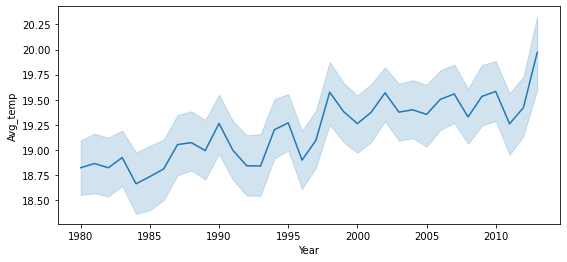

In [ ]:
plt.figure(figsize=(9,4))
sns.lineplot(x="Year",y="Avg_temp",data=latest_df)
plt.show()

It is clear now in the graph that the average temperature seems to be rising over the years.

Now, we are going to resample the time series to create a more sistinct line. 

In [ ]:
resample_df=latest_df[['Avg_temp']].resample('A').mean()

In [ ]:
resample_df.head()

,Avg_temp
Date,
1980-12-31,18.823582
1981-12-31,18.865545
1982-12-31,18.823059
1983-12-31,18.924548
1984-12-31,18.663822


We can also take a sample in which we add the minimum and maximum temperature in the year.

In [ ]:
resample_df2=latest_df[['Avg_temp']].resample('A').agg(['min','max', 'mean'])

In [ ]:
resample_df2.head()

Avg_temp                   
                min     max       mean
Date                                  
1980-12-31  -25.181  37.823  18.823582
1981-12-31  -21.752  36.851  18.865545
1982-12-31  -21.387  36.023  18.823059
1983-12-31  -19.927  37.495  18.924548
1984-12-31  -26.002  37.131  18.663822

In [ ]:
resample_df.head()

,Avg_temp
Date,
1980-12-31,18.823582
1981-12-31,18.865545
1982-12-31,18.823059
1983-12-31,18.924548
1984-12-31,18.663822


This is our resampled dataset.

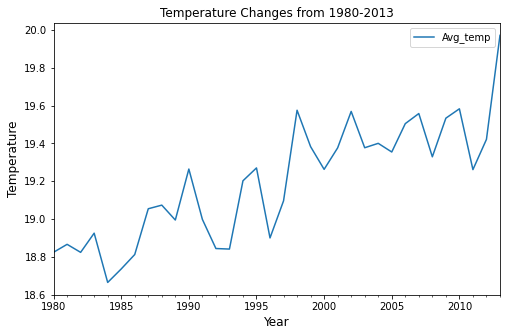

In [ ]:
resample_df.plot(title="Temperature Changes from 1980-2013", figsize=(8,5))
plt.ylabel('Temperature',fontsize=12)
plt.xlabel('Year',fontsize=12)
plt.legend()

#Stationnarity test 


Let's apply Dickey Fuller test to determine how stationnary our series is . 
In this case, our null hypothesis will be that the time series is not stationaary and is affected by trends. 

In [ ]:
from statsmodels.tsa.stattools  import adfuller 

print('Dickey Fuller test results: ')
test_df= adfuller(resample_df.iloc[:,0].values, autolag='AIC')
df_output=pd.Series(test_df[0:4],index=['Test statistic','p-value','Lags Used','Number of Observations Used'])
for key, value in test_df[4].items():
  df_output['Critical Value (%s) '%key] = value
print(df_output)

Dickey Fuller test results: 
Test statistic                 -0.590374
p-value                         0.873142
Lags Used                       2.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


So, here we can see that the test statistic is greater than the critical value.
We have failed to reject the null hypothesis which is "The time series data is not stationnary"
At this point our time series data is not stationnary. 

Now, we are going to decompose the data, extract components and then plot the original time series, the trend and the seasonal component.

Along with that, we will also plot the residual component graph.

In [ ]:
decomp= seasonal_decompose(resample_df,freq=3)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

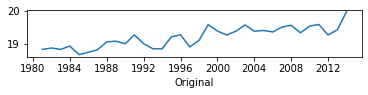

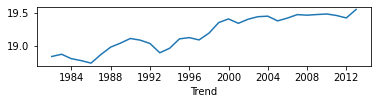

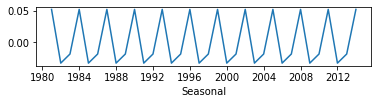

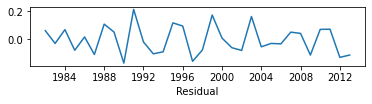

<Figure size 432x360 with 0 Axes>

In [ ]:
plt.subplot(411)
plt.plot(resample_df)
plt.xlabel('Original')
plt.figure(figsize=(6,5))

plt.subplot(412)
plt.plot(trend)
plt.xlabel('Trend')
plt.figure(figsize=(6,5))

plt.subplot(413)
plt.plot(seasonal)
plt.xlabel('Seasonal')
plt.figure(figsize=(6,5))

plt.subplot(414)
plt.plot(residual)
plt.xlabel('Residual')
plt.figure(figsize=(6,5))

plt.tight_layout()

We have an increasing trend line in the decomposition which proves that our data currently isn't stationnary.
We want the trend line to be constant over time.
So, we need to transform our data. 

#Data transformation

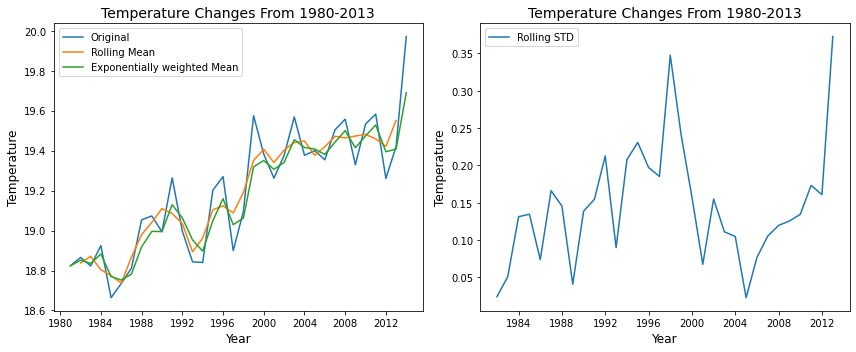

In [35]:
rol_mean= resample_df.rolling(window=3, center=True).mean()

ewm= resample_df.ewm(span=3).mean()

rol_std= resample_df.rolling(window=3,center=True).std()

fig, (ax1,ax2)= plt.subplots(1,2,figsize=(12,5))

ax1.plot(resample_df, label='Original')
ax1.plot(rol_mean,label='Rolling Mean')
ax1.plot(ewm,label='Exponentially weighted Mean')

ax1.set_title("Temperature Changes From 1980-2013", fontsize=14)
ax1.set_xlabel('Year',fontsize=12)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.legend()


ax2.plot(rol_std,label='Rolling STD')
ax2.set_title("Temperature Changes From 1980-2013", fontsize=14)
ax2.set_xlabel('Year',fontsize=12)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.legend()


plt.tight_layout()
plt.show()

So, we here we can see the graph of the original, rolling mean and he exponentially weighted mean. And also we have the graph of the rolling standard deviation. 
Now, let's apply again the dickey fuller test.

In [36]:
rol_mean.dropna(inplace=True)
ewm.dropna(inplace=True)

print('Dickey-Fuller Test for the Rolling Mean:')
df_test=adfuller(rol_mean.iloc[:,0].values,autolag='AIC')
df_output=pd.Series(df_test[0:4],index=['Test Statistic','p-value','Lags Used', 'Number Of Observations Used'])

for key,value in df_test[4].items(): 
  df_output['Critical Value(%s)' %key]=value
print(df_output)
print(' ')


print('Dickey-Fuller Test for the Exponentially Weighted Mean:')
df_test=adfuller(ewm.iloc[:,0].values,autolag='AIC')
df_output=pd.Series(df_test[0:4],index=['Test Statistic','p-value','Lags Used', 'Number Of Observations Used'])

for key,value in df_test[4].items(): 
  df_output['Critical Vlue(%s)' %key]=value
print(df_output)
print(' ')

Dickey-Fuller Test for the Rolling Mean:
Test Statistic                 -0.840435
p-value                         0.806955
Lags Used                       5.000000
Number Of Observations Used    26.000000
Critical Value(1%)             -3.711212
Critical Value(5%)             -2.981247
Critical Value(10%)            -2.630095
dtype: float64
 
Dickey-Fuller Test for the Exponentially Weighted Mean:
Test Statistic                 -0.224805
p-value                         0.935500
Lags Used                       2.000000
Number Of Observations Used    31.000000
Critical Vlue(1%)              -3.661429
Critical Vlue(5%)              -2.960525
Critical Vlue(10%)             -2.619319
dtype: float64
 


We can see that , again, both the test statistics are greater than the critical value. So, we have failed to reject the null hypothesis which state that the data is not stationnary.
At this point, we have a non stationaary time series data. 

Now, we are going to use differencing to remove the moving average or ewm from the original time series.

In [37]:
diff_rol_mean = resample_df - rol_mean
diff_rol_mean.dropna(inplace=True)
diff_rol_mean.head()

,Avg_temp
Date,
1981-12-31,0.028150
1982-12-31,-0.047992
1983-12-31,0.120738
1984-12-31,-0.110695
1985-12-31,-0.001687


In [38]:
diff_ewm = resample_df - ewm
diff_ewm.dropna(inplace=True)
diff_ewm.head()

,Avg_temp
Date,
1980-12-31,0.000000
1981-12-31,0.013988
1982-12-31,-0.012213
1983-12-31,0.041662
1984-12-31,-0.105999


Let's plot the difference graph with the rolling mean and the exponentially weighted mean.

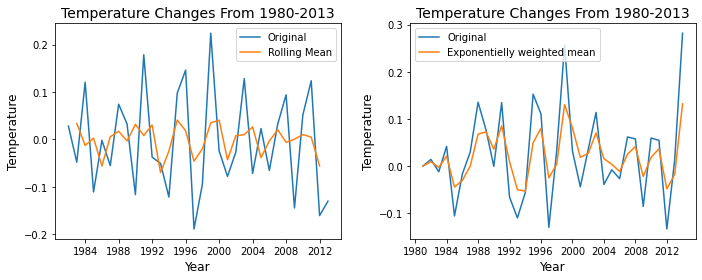

In [39]:
df_rol_mean_diff= diff_rol_mean.rolling(window=3, center=True).mean()

df_ewm_diff= diff_ewm.ewm(span=3).mean()



fig, (ax1,ax2)= plt.subplots(1,2,figsize=(10,4))

ax1.plot(diff_rol_mean, label='Original')
ax1.plot(df_rol_mean_diff,label='Rolling Mean')
ax1.set_title("Temperature Changes From 1980-2013", fontsize=14)
ax1.set_xlabel('Year',fontsize=12)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.legend()


ax2.plot(diff_ewm, label='Original')
ax2.plot(df_ewm_diff,label='Exponentielly weighted mean')
ax2.set_title("Temperature Changes From 1980-2013", fontsize=14)
ax2.set_xlabel('Year',fontsize=12)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.legend()


plt.tight_layout()
plt.show()

Now, we are going to apply the dickey fuller test and check our hypothesis.

In [41]:
print('Dickey-Fuller Test for the Rolling Mean:')
df_test=adfuller(diff_rol_mean.iloc[:,0].values,autolag='AIC')
df_output=pd.Series(df_test[0:4],index=['Test Statistic','p-value','Lags Used', 'Number Of Observations Used'])

for key,value in df_test[4].items(): 
  df_output['Critical Vlue(%s)' %key]=value
print(df_output)
print(' ')


print('Dickey-Fuller Test for the Exponentially Weighted Mean:')
df_test=adfuller(diff_ewm.iloc[:,0].values,autolag='AIC')
df_output=pd.Series(df_test[0:4],index=['Test Statistic','p-value','Lags Used', 'Number Of Observations Used'])

for key,value in df_test[4].items(): 
  df_output['Critical Vlue(%s)' %key]=value
print(df_output)
print(' ')

Dickey-Fuller Test for the Rolling Mean:
Test Statistic                 -5.098756
p-value                         0.000014
Lags Used                       3.000000
Number Of Observations Used    28.000000
Critical Vlue(1%)              -3.688926
Critical Vlue(5%)              -2.971989
Critical Vlue(10%)             -2.625296
dtype: float64
 
Dickey-Fuller Test for the Exponentially Weighted Mean:
Test Statistic                -6.928726e+00
p-value                        1.098080e-09
Lags Used                      1.000000e+00
Number Of Observations Used    3.200000e+01
Critical Vlue(1%)             -3.653520e+00
Critical Vlue(5%)             -2.957219e+00
Critical Vlue(10%)            -2.617588e+00
dtype: float64
 


So, here we can see in both cases that test statistics is less than critical value for both rolling mean and exponentially weighted mean.
This indicates that we can reject the null hypothesis and we are confident that the data is now stationnary. 

#Reviewing SARIMA with ACF and PACF 

We are going to review how we can find the parameters for seasonal autoregressive integrated moving average. 
It has parameters p, d and q which are autoregressive, integrated and moving average. 
So, to determine p and q parameters we are going to use autocorrestion function and partial autocorrection function. 

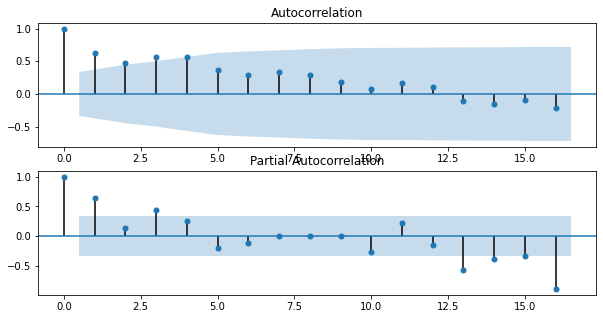

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot 

pyplot.figure(figsize=(10,5))
pyplot.subplot(211)
plot_acf(resample_df,ax=pyplot.gca())

pyplot.subplot(212)
plot_pacf(resample_df,ax=pyplot.gca())

pyplot.show()

So, here the p parameter will be the first value on partial autocorrection graph that is significally different from the previous values. 
The q parameter is the largest lag on the autocorrection plot that is significantly different from previous values. Hence, q could be 0 as there is no significant lag here.
Next, the d parameter will be the number of differences taken to make the time series stationnary. 